<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## What is a NBEATS?

Time series problems for predicting future value



## What to do



We've got a lot to go through. 

* Get time series data 
  * Load in time series data using pandas/Python's CSV module
* Format data for a time series problem
  * Creating training and test sets (75% traning data split and 25 %test )
  * Visualizing time series data
  * Turning time series data into a supervised learning problem (windowing)
* Evaluating a time series forecasting model
  * Replicating the N-BEATS algorithm 
* Results
* calculating required parameters MAE, MSE, RMSE, MAPE evaluation numbers on the rest of the 25% of the data.


### This is for Running in native or local (Windows)machine 





## CPU or GPU


In [2]:
# Check for GPU
!nvidia-smi -L

GPU 0: NVIDIA GeForce 940MX (UUID: GPU-c5f78b90-14b0-9b78-4a81-01df26d20bdf)


## Upload data
Resourse provided by the problem statement a git hub public repository created so that the data can be imported for the model to be trained upon 

## CSV data Columns
index ,value , timestamp  



In [3]:
import os.path
import numpy
from os import path
print(path.exists('content/0.csv'))
if path.exists('content/0.csv')==False: # check weather the files are already downloaded or not initialised by checking 1 file
  !wget https://raw.githubusercontent.com/tambeanuj123/tambeanuj123/main/dataset50/{-1..49}.csv
  !wget https://raw.githubusercontent.com/tambeanuj123/tambeanuj123/main/dataset50/temp.csv


True


###Adding code for keeping track of the file being retrieved and temporary csv saving the metrics data  

initially file when retrieved from the server holds no value only columns for 
*   **index**
*   **MAE**
*   **MSE**
*   **RMSE**
*   **MAPE**
*   **MASE**


these are filled and cheked which files have been ran through model and moves to next file on the next run 


In [4]:
import csv
# read
filecount=0       # change this value to the index of file you want to run first
with open('content/temp.csv', 'r') as file:
    reader = csv.reader(file)
    for rows in reader:
      filecount+= 1  #counts the current row in the csv
print("Number of lines present in temp csv file:-", filecount)    
file_number=(filecount%50)      #tells the file number being retrieved
print("file number being retrieved in the model:-",file_number,".csv") 

Number of lines present in temp csv file:- 1
file number being retrieved in the model:- 1 .csv


### Importing time series data with pandas


In [5]:
# Import with pandas 
import pandas as pd
# Parse value timestamo from the file
file_string=str(file_number)
df = pd.read_csv("content/"+file_string+".csv", 
                 parse_dates=["value"], 
                 index_col=["timestamp"]) # parse the timestamp column (tell pandas column 1 is a datetime)
df.head()

,Unnamed: 0,value
timestamp,,
1595323800,0,28.1641
1595327400,1,28.1823
1595331000,2,28.1979
1595334600,3,28.1641
1595338200,4,28.1771


Printing Dataframe info

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 840 entries, 1595323800 to 1598344200
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  840 non-null    int64 
 1   value       840 non-null    object
dtypes: int64(1), object(1)
memory usage: 19.7+ KB


In [7]:
# How many samples do we have?
len(df)

840

In [8]:
# renaming value df to price
value_df = pd.DataFrame(df["value"]).rename(columns={"value": "Price"})
value_df['Price'] = value_df['Price'].astype(float)
value_df.head()



,Price
timestamp,
1595323800,28.1641
1595327400,28.1823
1595331000,28.1979
1595334600,28.1641
1595338200,28.1771


Much better!

But that's only five days worth of Bitcoin prices, let's plot everything we've got.

              Price
timestamp          
1595323800  28.1641
1595327400  28.1823
1595331000  28.1979
1595334600  28.1641
1595338200  28.1771
...             ...
1598329800  28.5430
1598333400  28.5456
1598337000  28.5312
1598340600  28.5456
1598344200  28.5404

[840 rows x 1 columns]


<AxesSubplot: xlabel='timestamp'>

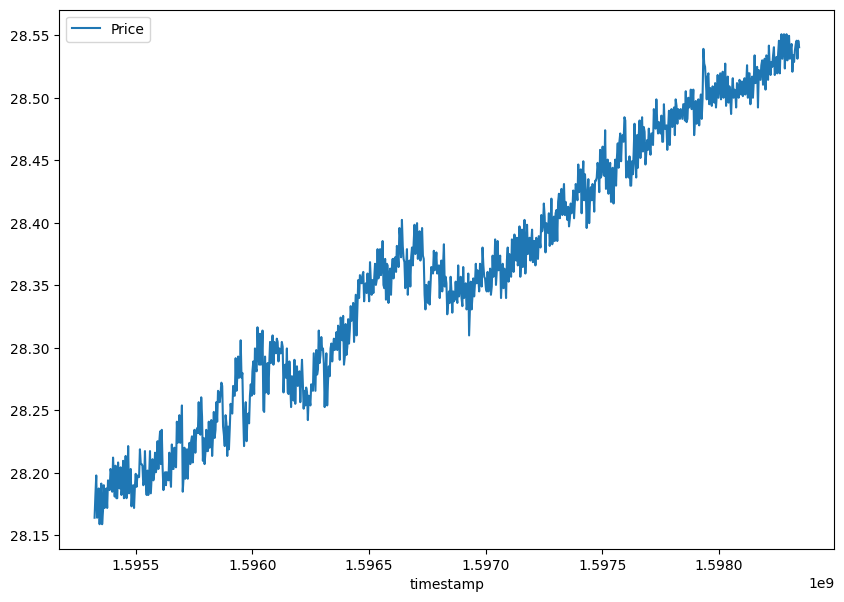

In [9]:
import matplotlib.pyplot as plt
print(value_df)
value_df.plot(figsize=(10, 7))


### Importing data with Python's CSV module
converting csv file 

In [10]:
# Importing and formatting csv data with Python
import csv

timesteps = []
value_column = []
with open("./content/"+file_string+".csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(float(line[2])) # get the value given in csv as float
    value_column.append(float(line[1])) # get the price as float

# View first 10 of each
timesteps[:10], value_column[:10]



([1595323800.0,
  1595327400.0,
  1595331000.0,
  1595334600.0,
  1595338200.0,
  1595341800.0,
  1595345400.0,
  1595349000.0,
  1595352600.0,
  1595356200.0],
 [28.1641,
  28.1823,
  28.1979,
  28.1641,
  28.1771,
  28.1875,
  28.1589,
  28.1784,
  28.1914,
  28.1589])

###Plotting the csv file


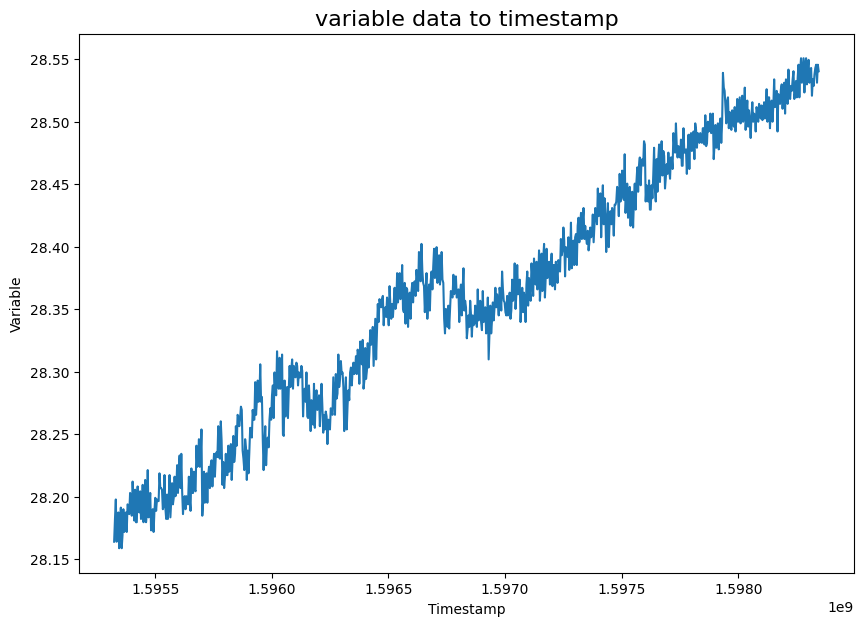

In [11]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps,value_column)
plt.title("variable data to timestamp", fontsize=16)
plt.xlabel("Timestamp")
plt.ylabel("Variable");

## train and test sets for time series data
Splitting the set into Training and Test data in first 75 percent in training and 25 percent in test data 

And now we'll use the ever faithful `train_test_split` from Scikit-Learn to create our train and test sets.

Looks like the splits worked well, but let's not trust numbers on a page, let's visualize, visualize, visualize!

#

In [12]:
# Create train and test splits the right way for time series data
split_size = int(0.75 * len(value_column)) # 75% train, 25% test

# Create train data splits (everything before the split)
X_train_original, y_train_original = timesteps[:split_size], value_column[:split_size]

# Create test data splits (everything after the split)
X_test_original, y_test_original = timesteps[split_size:], value_column[split_size:]

len(X_train_original), len(X_test_original), len(y_train_original), len(y_test_original)
print(y_test_original)

[28.4648, 28.4844, 28.4818, 28.4362, 28.4492, 28.4479, 28.4362, 28.4531, 28.4297, 28.4297, 28.4492, 28.4388, 28.456999999999997, 28.4792, 28.4466, 28.4362, 28.4701, 28.444000000000003, 28.4701, 28.4818, 28.4518, 28.4727, 28.4844, 28.456999999999997, 28.4766, 28.4727, 28.4466, 28.4557, 28.4661, 28.4583, 28.4753, 28.4622, 28.4544, 28.4714, 28.4714, 28.4622, 28.4909, 28.4805, 28.4753, 28.4987, 28.4805, 28.4714, 28.4805, 28.4779, 28.4714, 28.4857, 28.4648, 28.4648, 28.4948, 28.4753, 28.4753, 28.4779, 28.4583, 28.4753, 28.4896, 28.4622, 28.4883, 28.4909, 28.4766, 28.487, 28.4922, 28.4701, 28.4987, 28.4935, 28.4792, 28.4909, 28.4896, 28.4831, 28.4909, 28.487, 28.4831, 28.4948, 28.4948, 28.4818, 28.5052, 28.4805, 28.4831, 28.5, 28.4922, 28.4935, 28.5065, 28.4909, 28.4935, 28.5065, 28.4701, 28.4818, 28.4974, 28.4792, 28.4935, 28.4987, 28.4779, 28.4935, 28.5026, 28.4831, 28.4987, 28.5391, 28.5273, 28.5247, 28.5117, 28.4987, 28.5169, 28.5195, 28.4948, 28.5078, 28.5, 28.4935, 28.5091, 28.5, 28.49

### Importing ReVIN from the official implementation

Source =https://github.com/ts-kim/RevIN

Citation
If you find this work or code is helpful in your research, please cite:
***
@inproceedings{kim2021reversible,
  title     = {Reversible Instance Normalization for Accurate Time-Series Forecasting against Distribution Shift},
  author    = {Kim, Taesung and 
               Kim, Jinhee and 
               Tae, Yunwon and 
               Park, Cheonbok and 
               Choi, Jang-Ho and 
               Choo, Jaegul},
  booktitle = {International Conference on Learning Representations},
  year      = {2021},
  url       = {https://openreview.net/forum?id=cGDAkQo1C0p}
}
***

In [13]:
import torch
import torch.nn as nn

class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

### Instance Normalisation for ReVIAN implementation
instance normalising on the data and then splitting the data in training and test

### [Normalising] the data from the csv


In [14]:
num_features=1
revin_layer = RevIN(num_features)
input= numpy.array(value_column) # normalising the value column
tensor=torch.from_numpy(input)  # converting input set to tensor for normalising
# print(tensor)
value_column = revin_layer(tensor, 'norm')

value_column=value_column.detach()
value_column =value_column.numpy()
print(value_column[0:5]) # printing 5 values 



[-1.84417892 -1.67276069 -1.52583078 -1.84417892 -1.72173733]


In [15]:
# Create train and test splits
split_size = int(0.75 * len(value_column)) # 75% train, 25% test

# training data
X_train, y_train = timesteps[:split_size], value_column[:split_size]

# testing data
X_test, y_test = timesteps[split_size:], value_column[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(630, 210, 630, 210)

Visualising the training and test split data 

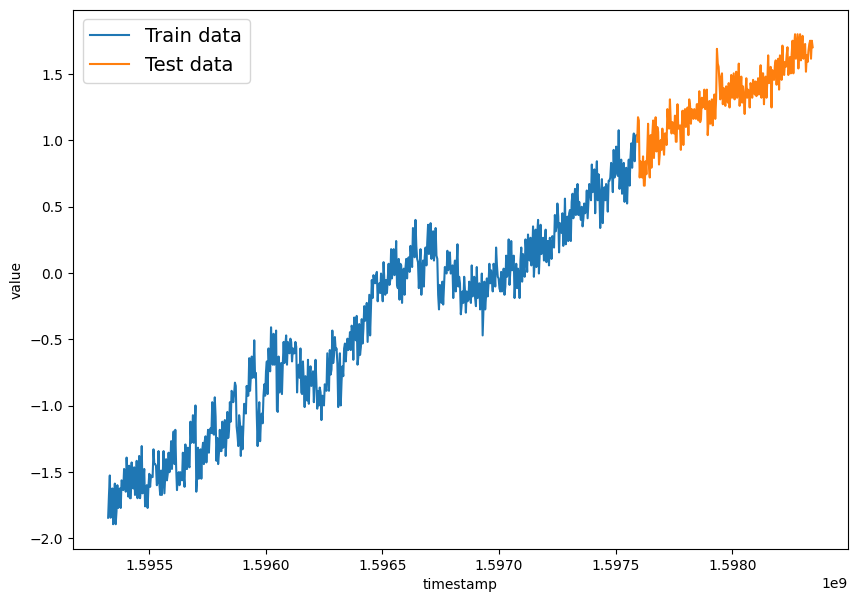

In [16]:
# Plot train and test splits
plt.figure(figsize=(10, 7))
plt.plot(X_train, y_train, label="Train data")
plt.plot(X_test, y_test, label="Test data")
plt.xlabel("timestamp")
plt.ylabel("value")
plt.legend(fontsize=14)
plt.savefig('img'+str(file_number)+'_first.png')
plt.show()


###  plotting function
defining a plotting function to be used again and again

In [17]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):

  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Timestamp")
  plt.ylabel("value")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

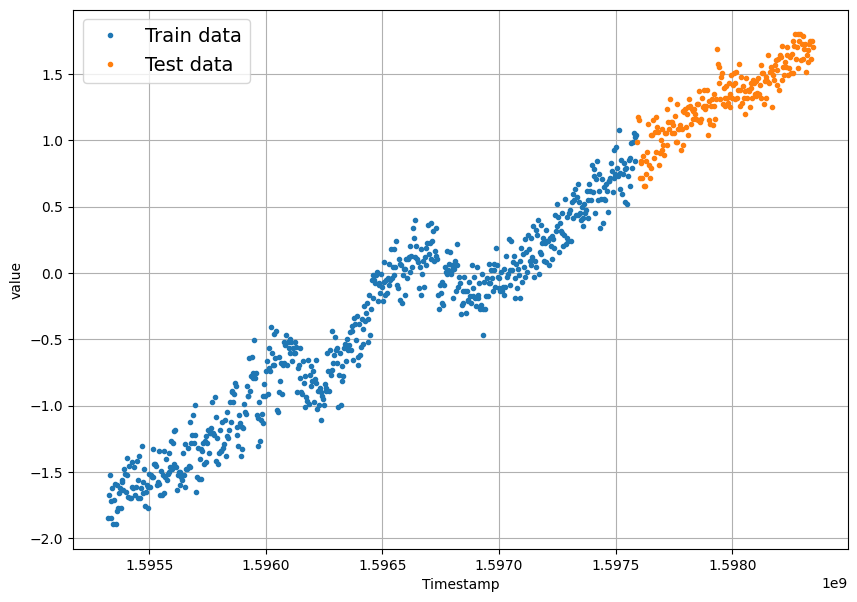

In [18]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Models

## creating test Naive prediction for finding MASE 

> Indented block


Testing forecast data by feeding the value with value of time [-1]

In [19]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:5], naive_forecast[-5:] # View first 5 and last 5 values

(array([0.98798927, 1.17259352, 1.1481052 , 0.71861777, 0.84105936]),
 array([1.6755459 , 1.72452254, 1.74901086, 1.61338325, 1.74901086]))

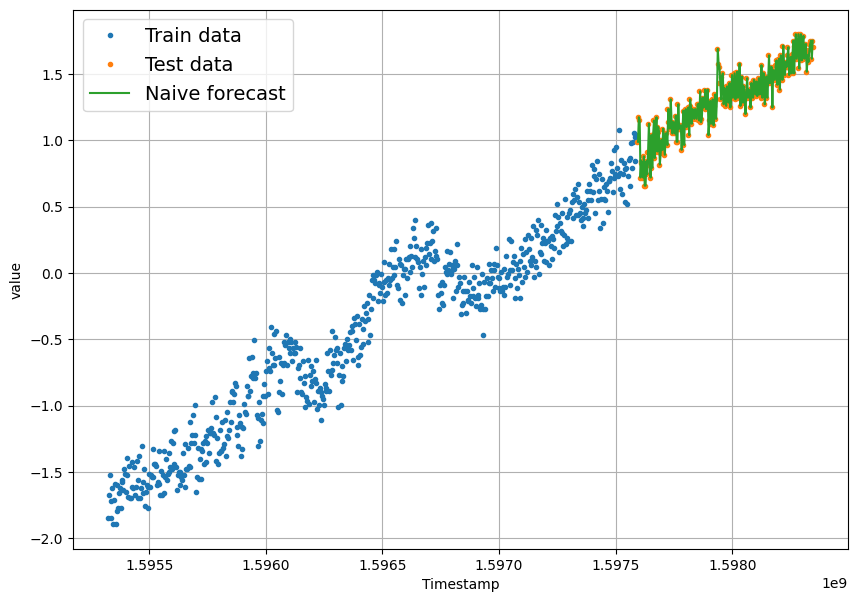

In [20]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

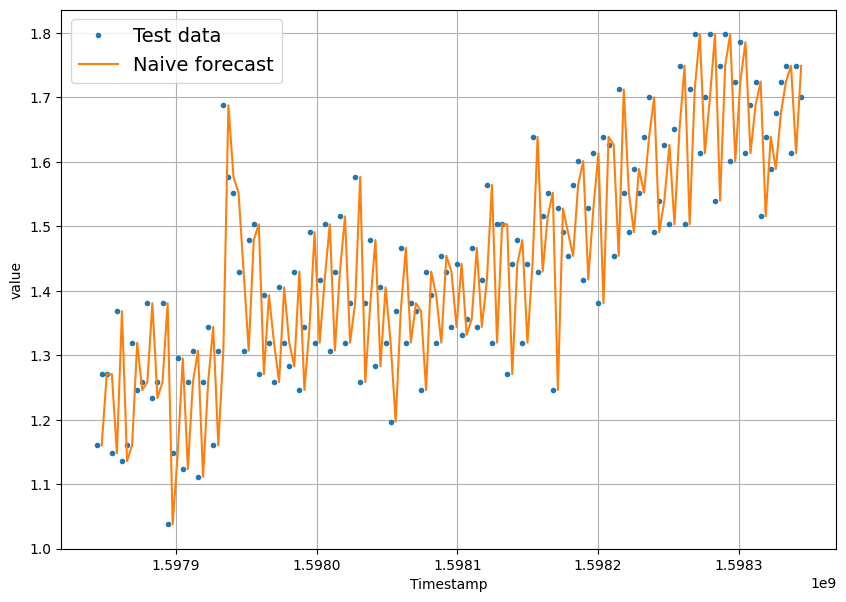

In [21]:
plt.figure(figsize=(10, 7))
offset = 70 # offset the values by 70 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

function for evaluating the metrics

1.   MASE 
2.   MSE 
3.   RMSE
4.   MApE


#NOTE  :- MASE need to be defined as it is not a  function in tf library

In [22]:
import tensorflow as tf

In [23]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [24]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float64)
  y_pred = tf.cast(y_pred, dtype=tf.float64)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

### implementing metrics on Naive prediction

In [25]:
print(type(y_test[0]))
print(len(naive_forecast))
y_test = np.asarray(y_test, dtype=float)
naive_forecast = np.asarray(naive_forecast, dtype=float)
print(type(y_test[0]))
naive_results = evaluate_preds(y_true=y_test[1:],y_pred=naive_forecast)
naive_results

<class 'numpy.float64'>
209
<class 'numpy.float64'>


{'mae': 0.1294717305733635,
 'mse': 0.023368119134634383,
 'rmse': 0.15286634402194088,
 'mape': 10.5630106932583,
 'mase': 1.0020514433716783}

## Windowing and Horizon


++++
Windowing is a method to turn a time series dataset into **supervised learning problem**. 
++++++

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```
for 1.csv value example

```
Window for 7 consecutive values with the target of predicting the next value

[28.1641,28.1823,28.1979,28.1641,28.1771,28.1875]  ->28.1589
[28.1823,28.1979,28.1641,28.1771,28.1875,28.1589]  ->28.1914
[28.1979,28.1641,28.1771,28.1875,28.1589,28.1914]  ->28.1589
[28.1641,28.1771,28.1875,28.1875,28.1589,28.1589]  ->28.1693
```

##initialising horizon size and window size

We'll start with the default horizon size of 1 and a window size of 7 \

In [26]:
HORIZON = 1 
WINDOW_SIZE = 7 

 a function to take in an array and turn it into a window and horizon.

In [27]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [28]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8



> 📖 **Resource:**(https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [29]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [30]:
# normalised data windowed
full_windows, full_labels = make_windows(value_column, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(833, 833)

In [31]:
# taking original window data for comparision
# full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
# len(full_windows), len(full_labels)

Of course we have to visualize, visualize, visualize!

In [32]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [-1.84417892 -1.67276069 -1.52583078 -1.84417892 -1.72173733 -1.62378406
 -1.89315556] -> Label: [-1.70949317]
Window: [-1.67276069 -1.52583078 -1.84417892 -1.72173733 -1.62378406 -1.89315556
 -1.70949317] -> Label: [-1.58705158]
Window: [-1.52583078 -1.84417892 -1.72173733 -1.62378406 -1.89315556 -1.70949317
 -1.58705158] -> Label: [-1.89315556]


In [33]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [1.72452254 1.51542997 1.63881342 1.58889493 1.6755459  1.72452254
 1.74901086] -> Label: [1.61338325]
Window: [1.51542997 1.63881342 1.58889493 1.6755459  1.72452254 1.74901086
 1.61338325] -> Label: [1.74901086]
Window: [1.63881342 1.58889493 1.6755459  1.72452254 1.74901086 1.61338325
 1.74901086] -> Label: [1.70003422]


###  RIVIAN normallisation
## Reference official implementation
https://github.com/ts-kim/RevIN



### Trying to understand REviAN

## Turning windows into training and test sets 



In [34]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.25):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 75% train/25% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

Look at that amazing function, lets test it.

In [35]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(624, 209, 624, 209)

looking at the sample 5 sample of the windowed element

In [36]:
train_windows[:5], train_labels[:5]

(array([[-1.84417892, -1.67276069, -1.52583078, -1.84417892, -1.72173733,
         -1.62378406, -1.89315556],
        [-1.67276069, -1.52583078, -1.84417892, -1.72173733, -1.62378406,
         -1.89315556, -1.70949317],
        [-1.52583078, -1.84417892, -1.72173733, -1.62378406, -1.89315556,
         -1.70949317, -1.58705158],
        [-1.84417892, -1.72173733, -1.62378406, -1.89315556, -1.70949317,
         -1.58705158, -1.89315556],
        [-1.72173733, -1.62378406, -1.89315556, -1.70949317, -1.58705158,
         -1.89315556, -1.79520228]]),
 array([[-1.70949317],
        [-1.58705158],
        [-1.89315556],
        [-1.79520228],
        [-1.59929574]]))

### For Personal use(**Ignore** the commented out part below)

In [37]:
#  num_features=1
#  import numpy
#  revin_layer = RevIN(num_features)
#  input = train_windows
#  tensor = torch.from_numpy(input)
#  print(torch.randn(1, 100, 40))
#  print(input)
#  print(tensor)
#  x_in = revin_layer(tensor, 'norm')
#  print(x_in)
#  x_in.detach()
#  print(x_in)
#  x_in = x_in.detach()
#  print(x_in)
#  x_in =x_in.numpy()
#  print(x_in)

#  #denormalise
#  x_out=x_in
#  x_out_tensor = torch.from_numpy(x_out)
#  print(x_out_tensor)
#  x_out = revin_layer(x_out_tensor, 'denorm')
#  print(x_out)
#  x_out=x_out.detach()
#  x_out =x_out.numpy()
#  print(x_out)



#  print(x_in)
#  x_out = revin_layer(x_in, 'denorm')
#  print(x_out)

### Visualising the  Normalised data(ignore the commented out part below)

In [38]:

#  #getting normalised array in 1D for visualisation for plotting
#  plot_arr=[]
#  for i in range(len(x_in)):
#    plot_arr.append(x_in[i][0])
#  for i in range(1,len(x_in[-1])):
#    plot_arr.append(x_in[-1][i])
#  print(plot_arr)
#  print(len(plot_arr))
#  print(X_train)
# #  print(len(x_in))
#  print(len(X_train))
# #  plt.figure(figsize=(10, 7))         un comment for scatter plot
# #  plot_time_series(timesteps=X_train, values=plot_arr, label="Normalised data visualisation")  
# plt.figure(figsize=(10, 7))
# plt.plot(X_train,y_train)
# plt.plot(X_test,y_test)
# plt.title("variable training data to timestamp Normalised", fontsize=16)
# plt.xlabel("Timestamp")
# plt.ylabel("Variable");

In [39]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

False

## Make a modelling checkpoint(optional)
To do this, we'll write a small function to create a `ModelCheckpoint` callback which saves a model to specified filename.

In [40]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

Training and test multivariate time series datasets made! Time to build a model.

## implementing : N-BEATS algorithm



![figure 1 from N-BEATS paper, the algorithm we're going to build](https://raw.githubusercontent.com/ServiceNow/N-BEATS/master/nbeats.png)




### Building and testing an N-BEATS block layer

Let's start by building an N-BEATS block layer, we'll write the code first and then discuss what's going on.

In [41]:
# Create NBeatsBlock custom layer 
import tensorflow as tf
from tensorflow.keras import layers
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

### Setting up NBEATS BLOCK:

Setting up the `NBeatsBlock` custom layer we see: 
* The class inherits from `tf.keras.layers.Layer` (this gives it all of the methods assosciated with `tf.keras.layers.Layer`)
* The constructor (`def __init__(...)`) takes all of the layer hyperparameters as well as the `**kwargs` argument
  * The `**kwargs` argument takes care of all of the hyperparameters which aren't mentioned in the constructor such as, `input_shape`, `trainable` and `name`
* In the constructor, the block architecture layers are created:
  * The hidden layers are created as a stack of fully connected with `n_nuerons` hidden units layers with ReLU activation
  * The theta layer uses `theta_size` hidden units as well as linear activation
* The `call()` method is what is run when the layer is called:
  * It first passes the inputs (the historical Bitcoin data) through each of the hidden layers (a stack of fully connected layers with ReLU activation)
  * After the inputs have been through each of the fully connected layers, they get passed through the theta layer where the backcast (backwards predictions, shape: `input_size`) and forecast (forward predictions, shape: `horizon`) are returned

In [42]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [43]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [44]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.02269751  0.20175692 -0.05504559  0.7509524  -0.7308315   0.6159002
  0.3044127 ]
Forecast: 0.7236296534538269


### Preparing data for the N-BEATS algorithm using `tf.data`

We've got the basic building block for the N-BEATS architecture ready to go.

But before we use it to replicate the entire N-BEATS generic architecture, let's create some data.

 the N-BEATS algorithm Univariate Function

In [45]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

### csv for the normalised dataframe to be fed into NBEAT Algoritmn


```
# storing normalised values temporarily in "-1.csv" file 
```




In [46]:
import csv
# read
"""
with open('./content/-1.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        print(row)
# writing values
"""
value_column_list=value_column.tolist()
f = open("./content/-1.csv", "w")
f.truncate()
with open('./content/-1.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["", "value", "timestamp"]) 
    for i in range(len(value_column_list)):
        writer.writerow([i, value_column_list[i],int(timesteps[i])])

   
# empty the truncated file

# f = open("-1.csv", "w")
# f.truncate()


### importing the df from normalised csv temp file named -1.csv

In [47]:
# Import with pandas 
import pandas as pd
# Parse value timestamo from the 1.csv file
df_temp = pd.read_csv("./content/-1.csv", 
                 parse_dates=["value"], 
                 index_col=["timestamp"]) # parse the timestamp column (tell pandas column 1 is a datetime)
df_temp.head()

,Unnamed: 0,value
timestamp,,
1595323800,0,-1.8441789201909644
1595327400,1,-1.672760692291568
1595331000,2,-1.5258307826635238
1595334600,3,-1.8441789201909644
1595338200,4,-1.7217373288342719


In [48]:
# renaming value df to price
value_df_temp = pd.DataFrame(df_temp["value"]).rename(columns={"value": "Price"})
value_df_temp['Price'] = value_df_temp['Price'].astype(float)
value_df_temp.head()
df_temp.head()

,Unnamed: 0,value
timestamp,,
1595323800,0,-1.8441789201909644
1595327400,1,-1.672760692291568
1595331000,2,-1.5258307826635238
1595334600,3,-1.8441789201909644
1595338200,4,-1.7217373288342719


In [49]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
print(value_df_temp.head())
# timesteps = numpy.array(timesteps)
# print(type(value_column))
value_column_list=value_column.tolist()
# print(value_column_list)
# print(timesteps)
# print(type(value_column))
# print(value_df)

  
# Calling DataFrame constructor after zipping
# both lists, with columns specified
normalised_df = pd.DataFrame(list(zip(timesteps, value_column_list)),
               columns =['timestamp', 'Price'])
print(normalised_df.head())


               Price
timestamp           
1595323800 -1.844179
1595327400 -1.672761
1595331000 -1.525831
1595334600 -1.844179
1595338200 -1.721737
      timestamp     Price
0  1.595324e+09 -1.844179
1  1.595327e+09 -1.672761
2  1.595331e+09 -1.525831
3  1.595335e+09 -1.844179
4  1.595338e+09 -1.721737


In [50]:
# Add windowed columns
value_df_nbeats = value_df_temp.copy()   # commenting this line and uncommenting this line will implement standard NBEAt Algorithmn
# value_df_nbeats = value_df.copy()    #uncommenting and commenting the above line will unimplement the ReVIN
for i in range(WINDOW_SIZE):
  value_df_nbeats[f"Price+{i+1}"] = value_df_nbeats["Price"].shift(periods=i+1)
value_df_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
timestamp,,,,,,,,
1595349000,-1.709493,-1.893156,-1.623784,-1.721737,-1.844179,-1.525831,-1.672761,-1.844179
1595352600,-1.587052,-1.709493,-1.893156,-1.623784,-1.721737,-1.844179,-1.525831,-1.672761
1595356200,-1.893156,-1.587052,-1.709493,-1.893156,-1.623784,-1.721737,-1.844179,-1.525831
1595359800,-1.795202,-1.893156,-1.587052,-1.709493,-1.893156,-1.623784,-1.721737,-1.844179
1595363400,-1.599296,-1.795202,-1.893156,-1.587052,-1.709493,-1.893156,-1.623784,-1.721737


In [51]:
# Make features and labels
X = value_df_nbeats.dropna().drop("Price", axis=1)
y = value_df_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.75)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)
print(X_test)

             Price+1   Price+2   Price+3   Price+4   Price+5   Price+6  \
timestamp                                                                
1597595400  0.987989  1.037908  1.025664  0.841059  1.050152  0.987989   
1597599000  1.172594  0.987989  1.037908  1.025664  0.841059  1.050152   
1597602600  1.148105  1.172594  0.987989  1.037908  1.025664  0.841059   
1597606200  0.718618  1.148105  1.172594  0.987989  1.037908  1.025664   
1597609800  0.841059  0.718618  1.148105  1.172594  0.987989  1.037908   
...              ...       ...       ...       ...       ...       ...   
1598329800  1.675546  1.588895  1.638813  1.515430  1.724523  1.687790   
1598333400  1.724523  1.675546  1.588895  1.638813  1.515430  1.724523   
1598337000  1.749011  1.724523  1.675546  1.588895  1.638813  1.515430   
1598340600  1.613383  1.749011  1.724523  1.675546  1.588895  1.638813   
1598344200  1.749011  1.613383  1.749011  1.724523  1.675546  1.588895   

             Price+7  
timestamp     

C:\Users\tambe\AppData\Local\Temp\ipykernel_14692\2252614789.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_train, y_train = X[:split_size], y[:split_size]
C:\Users\tambe\AppData\Local\Temp\ipykernel_14692\2252614789.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_test, y_test = X[split_size:], y[split_size:]


Train and test sets ready to go!

Now let's convert them into TensorFlow `tf.data.Dataset`'s to ensure they run as fast as possible whilst training.

We'll do this by:
1. Turning the arrays in tensor Datasets using [`tf.data.Dataset.from_tensor_slices()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
  * Note: `from_tensor_slices()` works best when your data fits in memory, for extremely large datasets, you'll want to look into using the [`TFRecord` format](https://www.tensorflow.org/tutorials/load_data/tfrecord)
2. Combine the labels and features tensors into a Dataset using [`tf.data.Dataset.zip()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip)
3. Batch and prefetch the Datasets using [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)
  * Batching and prefetching ensures the loading time from CPU (preparing data) to GPU (computing on data) is as small as possible 

> 📖 **Resource:** For more on building highly performant TensorFlow data pipelines, I'd recommend reading through the [*Better performance with the tf.data API*](https://www.tensorflow.org/guide/data_performance) guide.

In [52]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

Data prepared! Notice the input shape for the features `(None, 7)`, the `None` leaves space for the batch size where as the `7` represents the `WINDOW_SIZE`.

Time to get create the N-BEATS architecture. 

### Setting up hyperparameters for N-BEATS algorithm


hyperparameters from the Paper
> 📖 **Resource:** The following hyperparameters are taken from Figure 1 and Table 18/Appendix D of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).

![table  from N-BEATS paper](https://raw.githubusercontent.com/tambeanuj123/tambeanuj123/main/hyperparameters.png)
*Table from [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) describing the hyperparameters used for the different variants of N-BEATS. We're using N-BEATS-G which stands for the generic version of N-BEATS.*

>  **Note:** capping the parameter and runnning epochs =50 rather than 5000 suggested in paper experiments due to lack of time you can change it in N_EPOCHS = int 
variable 



In [53]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 500 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Beautiful! Hyperparameters ready, now before we create the N-BEATS model, there are two layers to go through which play a large roll in the architecture.

They're what make N-BEATS **double residual stacking** (section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)) possible:
* [`tf.keras.layers.subtract(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/subtract) - subtracts list of input tensors from each other
* [`tf.keras.layers.add(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/add) - adds list of input tensors to each other

Let's try them out.

In [54]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = tf.keras.layers.subtract([tensor_1, tensor_2])

# Add
added = tf.keras.layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


Both of these layer functions are straight-forward, subtract or add together their inputs.

And as mentioned before, they're what powers N-BEATS double residual stacking.

The power of **residual stacking** or **residual connections** was revealed in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) where the authors were able to build a deeper but less complex neural network (this is what introduced the popular [ResNet architecture](https://en.wikipedia.org/wiki/Residual_neural_network)) than previous attempts. 

This deeper neural network led to state of the art results on the ImageNet challenge in 2015 and different versions of residual connections have been present in deep learning ever since.

> What is a residual connection?

A **residual connection** (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:
* Subtract the backcast outputs from a previous block from the backcast inputs to the current block
* Add the forecast outputs from all blocks together in a stack 

![N-BEATS architecture double residual stacking](https://raw.githubusercontent.com/ServiceNow/N-BEATS/master/nbeats.png)
*Annotated version of Figure 1 from the N-BEATS paper highlighting the double residual stacking (section 3.2) of the architecture. Backcast residuals of each block are subtracted from each other and used as the input to the next block where as the forecasts of each block are added together to become the stack forecast.*

> What are the benefits of residual connections?

In practice, residual connections have been beneficial for training deeper models (N-BEATS reaches ~150 layers, also see "These approaches provide clear advantages in improving the trainability of deep architectures" in section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).  

It's thought that they help avoid the problem of [vanishing gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) (patterns learned by a neural network not being passed through to deeper layers).



### Building, compiling and fitting the N-BEATS algorithm 

Okay, we've finally got all of the pieces of the puzzle ready for building and training the N-BEATS algorithm.

We'll do so by going through the following:

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * [`tf.keras.callbacks.EarlyStopping()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using `restore_best_weights=True` (this'll prevent the model from training for loooongggggg period of time without improvement)
  * [`tf.keras.callbacks.ReduceLROnPlateau()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

Woah. A bunch of steps. But I'm sure you're up to it.

Let's do it!

## Making forecasts with a model (on the test dataset)




In [55]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions



In [56]:
 %%time

tf.random.set_seed(42)
print(tf.random.set_seed(42))
# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link,
residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")
  
# 7. Put the stack model together
nbeat_model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
nbeat_model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
nbeat_model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

None

Epoch 150: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 250: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: total: 2min 26s
Wall time: 3min 7s


### Performance

In [57]:
# Evaluate N-BEATS model on the test dataset
nbeat_model.evaluate(test_dataset)

1/1 [==============================] - 0s 239ms/step - loss: 0.0604 - mae: 0.0604 - mse: 0.0071


[0.060440272092819214, 0.060440272092819214, 0.007144555449485779]

In [58]:
# Make predictions with N-BEATS model
nbeat_model_preds = make_preds(nbeat_model, test_dataset)
nbeat_model_preds[:10]

1/1 [==============================] - 5s 5s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.1045377 , 1.090734  , 1.0266553 , 1.0079167 , 0.95015365,
       0.7739602 , 0.89588773, 0.7120274 , 0.6395515 , 0.82445437],
      dtype=float32)>

Visualising the predicted data

209
209
tf.Tensor(
[1.1045377  1.090734   1.0266553  1.0079167  0.95015365 0.7739602
 0.89588773 0.7120274  0.6395515  0.82445437 0.6707294  0.71462405
 0.9055247  0.80613977 0.92217034 0.9757988  0.7833013  0.8772852
 1.0396609  0.8225913  0.9635081  1.1716143  0.9194491  1.1258212
 1.1529944  0.9058199  1.0554394  1.0171846  0.8133998  0.98693347
 0.98382634 0.9021867  1.0400516  1.0051335  0.9708852  1.1024094
 1.0319141  1.0786574  1.2343585  1.1455495  1.1334785  1.3094559
 1.0765007  1.090891   1.1747166  1.0663149  1.0375481  1.1384788
 1.0327636  1.0763994  1.247756   1.0130806  1.021633   1.1856195
 0.94946605 1.1064032  1.1853857  1.0479188  1.2462453  1.2583467
 1.0880008  1.2602552  1.2381254  1.1324244  1.3019615  1.2490296
 1.1211541  1.3301105  1.2050202  1.1622037  1.2681165  1.2174265
 1.2196362  1.2887921  1.2589774  1.1749765  1.3181568  1.1664958
 1.2133131  1.3818873  1.2151004  1.3063124  1.3937153  1.2560716
 1.2124392  1.3138027  1.057409   1.2292643  1.2858702 

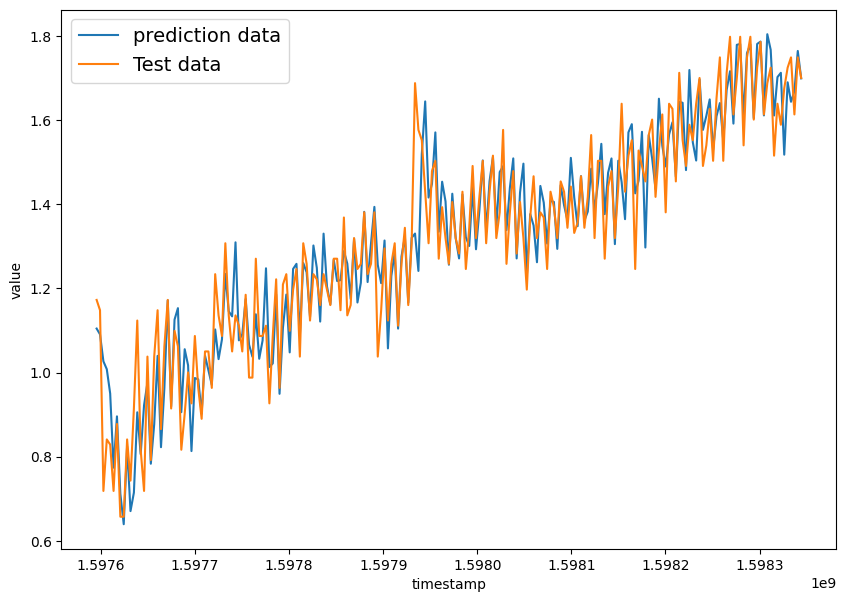

In [59]:

print(len(X_test))
print(len(nbeat_model_preds))
print(nbeat_model_preds)
plt.figure(figsize=(10, 7))
X_testdata = timesteps[split_size+WINDOW_SIZE:]  # adding window size cause the window size decreases the prediction 
print(X_testdata)
plt.plot(X_testdata, nbeat_model_preds, label="prediction data")
plt.plot(X_testdata, y_test , label="Test data")
plt.xlabel("timestamp")
plt.ylabel("value")
plt.legend(fontsize=14)
plt.savefig('img'+str(file_number)+'_prediction.png')
plt.show()


Reverse Instance NOrmalisation

In [60]:
# denormalise
# print(nbeat_model_preds)
# x_out_test=x_in_test
y_out_test=nbeat_model_preds
y_out_test=y_out_test.numpy()
y_out_tensor = torch.from_numpy(y_out_test)
print(y_out_tensor)
# #denormalise end
y_out = revin_layer(y_out_tensor, 'denorm')
# print(x_out)
# print(x_out)
y_out=y_out.detach()
y_out =y_out.numpy()
print(y_out)

tensor([1.1045, 1.0907, 1.0267, 1.0079, 0.9502, 0.7740, 0.8959, 0.7120, 0.6396,
        0.8245, 0.6707, 0.7146, 0.9055, 0.8061, 0.9222, 0.9758, 0.7833, 0.8773,
        1.0397, 0.8226, 0.9635, 1.1716, 0.9194, 1.1258, 1.1530, 0.9058, 1.0554,
        1.0172, 0.8134, 0.9869, 0.9838, 0.9022, 1.0401, 1.0051, 0.9709, 1.1024,
        1.0319, 1.0787, 1.2344, 1.1455, 1.1335, 1.3095, 1.0765, 1.0909, 1.1747,
        1.0663, 1.0375, 1.1385, 1.0328, 1.0764, 1.2478, 1.0131, 1.0216, 1.1856,
        0.9495, 1.1064, 1.1854, 1.0479, 1.2462, 1.2583, 1.0880, 1.2603, 1.2381,
        1.1324, 1.3020, 1.2490, 1.1212, 1.3301, 1.2050, 1.1622, 1.2681, 1.2174,
        1.2196, 1.2888, 1.2590, 1.1750, 1.3182, 1.1665, 1.2133, 1.3819, 1.2151,
        1.3063, 1.3937, 1.2561, 1.2124, 1.3138, 1.0574, 1.2293, 1.2859, 1.1044,
        1.2756, 1.3233, 1.1659, 1.3201, 1.3303, 1.2415, 1.5190, 1.6443, 1.4159,
        1.4482, 1.5707, 1.3345, 1.4535, 1.4069, 1.2562, 1.4250, 1.3198, 1.2712,
        1.4230, 1.3215, 1.3007, 1.4407, 

### visualising the Reverse normalised resultant graph


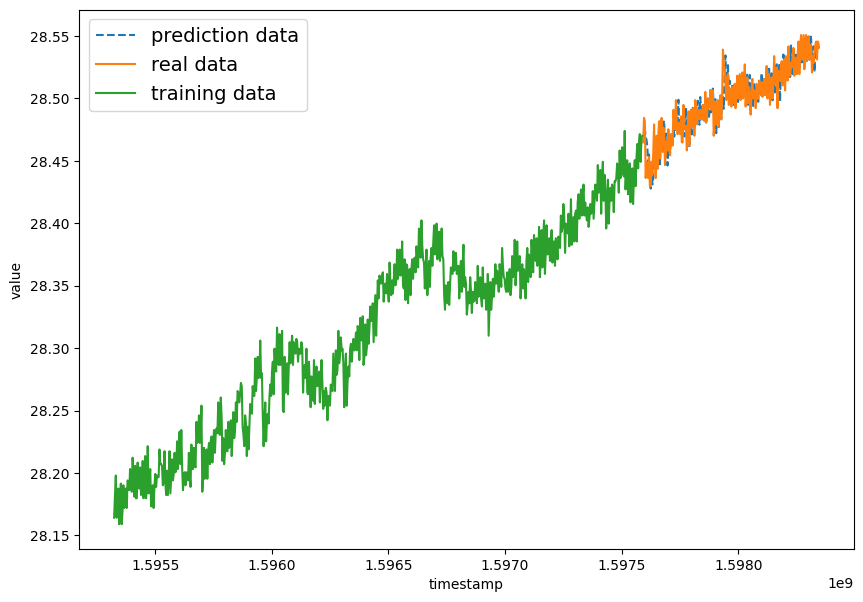

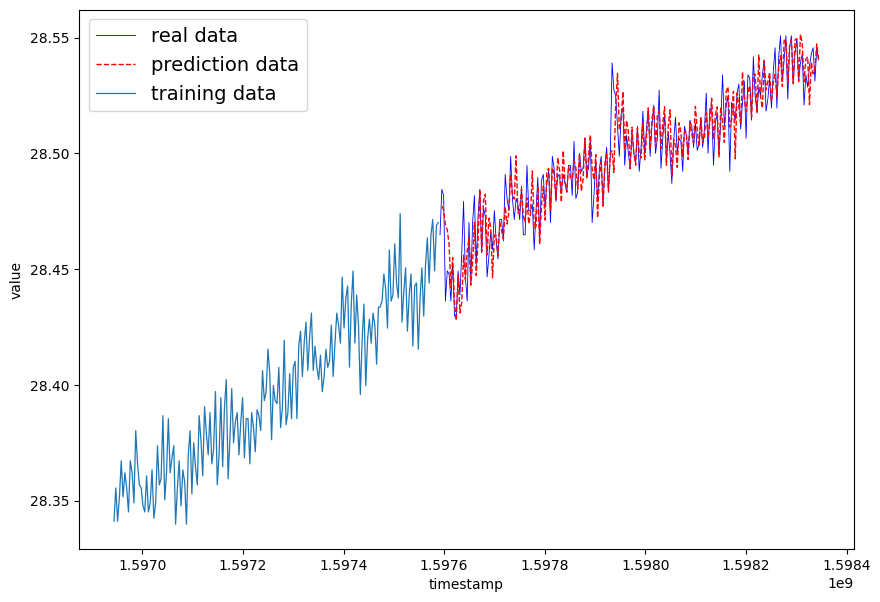

In [61]:
plt.figure(figsize=(10, 7))
plt.plot(X_testdata, y_out, label="prediction data",linestyle='dashed')
plt.plot(X_test_original, y_test_original, label="real data")
plt.plot(X_train_original, y_train_original , label="training data")
plt.xlabel("timestamp")
plt.ylabel("value")
plt.legend(fontsize=14)
plt.savefig('img'+str(file_number)+'_full_prediction.png')
plt.show()


plt.figure(figsize=(10, 7))
plt.plot(X_test_original, y_test_original, label="real data",color='blue',linewidth=0.6)
plt.plot(X_testdata, y_out, label="prediction data",color='red',linestyle='dashed',linewidth=1.0)

plt.plot(X_train_original[450:], y_train_original[450:] , label="training data",linewidth=0.9)
plt.xlabel("timestamp")
plt.ylabel("value")
plt.legend(fontsize=14)
plt.savefig('img'+str(file_number)+'full_cut_prediction.png')
plt.show()


In [62]:
# Evaluate N-BEATS model predictions
nbeat_model_results = evaluate_preds(y_true=y_test,
                                 y_pred=nbeat_model_preds)
nbeat_model_results
print(nbeat_model_results)

{'mae': 0.060440276247380985, 'mse': 0.00714455580030673, 'rmse': 0.08452547426845193, 'mape': 4.929487025059512, 'mase': 0.46777984493806635}


 ### Adding the values of mae ,mse ,rmse,mape,mase to the temp csv file

 This file is mentioned on the top to keep track of which file is being **used**

In [63]:
print("The name of the file being evaluvated ==> " +file_string+".csv")
file_path="./content/temp.csv"
with open(file_path, 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([int(file_number), nbeat_model_results['mae'],nbeat_model_results['mse'],nbeat_model_results['rmse'],nbeat_model_results['mape'],nbeat_model_results['mase']])
   


The name of the file being evaluvated ==> 1.csv



### Plotting the N-BEATS architecture we've created (optional)



plotting our model using [`tensorflow.keras.utils.plot_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).



In [64]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(nbeat_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
